In [1]:
import torch
from tqdm import tqdm
from pathlib import Path
import json
from datetime import datetime
#from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
# import pandas as pd
# import random
# from collections import Counter
import evaluate

from transformers import AutoTokenizer, GPT2LMHeadModel
from transformers import BertTokenizerFast
import os
# os.environ["TOKENIZERS_PARALLELISM"] = "false" #необходимо на виртуальной машине Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
# ./src
from src.data_utils import samples_preparation, load_datasets,load_samples,dataset_preparation#,load_and_clean_data, prepare_training_pairs
#from src.next_token_dataset import TweetsDataset
from src.lstm_model import NextPhrasePredictionRNN
from src.eval_lstm import vevaluate3, test_model, analyze_predictions, analyze_error_patterns, show_detailed_examples
from src.visualization import create_visualization
# для тестирования и сравнения тестов по lstm и distilgpt2
# from src.test_models import test_lstm_model #, test_transformer_model_new,prepare_transformer_dataset_from_loader, test_transformer_with_generation, compare_models
# test_transformer_with_generation,create_test_dataset, test_lstm_model,prepare_transformer_dataset,test_transformer_model,compare_models
# подготовка таблицы сравнения результатов вывода между моделями
# from src.test_models_table import create_test_dataset, load_lstm_model,generate_lstm_completion,generate_gpt2_completion,calculate_rouge,get_actual_continuation,create_comparison_table
# from src.test_comparison_table import compare_models_lstm_vs_gpt2

In [2]:
# pip install torch torchvision --index-url https://download.pytorch.org/whl/cu128

In [3]:
#оставляем в главном коде
def train_epoch(model, loader, optimizer, criterion, device):
    model.train()
    total_loss = 0
    progress_bar = tqdm(loader, desc="Train", leave=False)
    
    for batch in progress_bar:
        ids = batch['data'].to(device)
        mask = batch['mask'].to(device)
        labels = batch['target'].to(device)

        optimizer.zero_grad()
        logits = model(ids, mask)
        
        logits_flat = logits.reshape(-1, logits.size(-1))
        labels_flat = labels.reshape(-1)
        
        loss = criterion(logits_flat, labels_flat)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

        total_loss += loss.item()
        progress_bar.set_postfix({"Loss": f"{loss.item():.4f}"})
        
    return total_loss / len(loader)

In [4]:
def save_model(model, optimizer, epoch, accuracy, loss, path, tokenizer, config):
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'accuracy': accuracy,
        'loss': loss,       
        'model_config': {
            'vocab_size': config['vocab_size'],
            'emb_dim': config['emb_dim'],
            'hidden_dim': config['hidden_dim'],
            'num_layers':config['num_layers'],
            'pad_idx': config['pad_idx']           
        }
    }, path)


In [5]:
# Конфигурация
current_dir = Path(os.getcwd())
# print(current_dir)
#   'file_path': Path(__file__).parent.parent / 'data' / '1_raw_dataset_tweets.txt',
#     'model_dir': Path(__file__).parent.parent / 'models',  
tokenizer = BertTokenizerFast.from_pretrained("bert-base-uncased")
config = {
    'data_dir': Path(current_dir) / 'data',
    'source_file': '1_raw_dataset_tweets.txt',
    'model_dir': Path(current_dir) / 'models',
    'MAX_LEN': 10,
    'num_epoch':100,
    'limit': 500000,
    'num_layers':2,
    'hidden_dim': 128, #128#256#512
    'emb_dim': 300,
    'batch_size': 64,#256
    'rnn_type': "LSTM",#"GRU",#"LSTM",
    'tokenizer': tokenizer,
    'pad_idx':tokenizer.pad_token_id,
    'vocab_size': tokenizer.vocab_size,
    'compute_rouge': True
}


print('Config: ',config)

config['model_dir'].mkdir(exist_ok=True)


Config:  {'data_dir': WindowsPath('c:/Users/OMEN/Documents/LLM_Test/YaPracticum/project1_text-autocomplete_v3/data'), 'source_file': '1_raw_dataset_tweets.txt', 'model_dir': WindowsPath('c:/Users/OMEN/Documents/LLM_Test/YaPracticum/project1_text-autocomplete_v3/models'), 'MAX_LEN': 10, 'num_epoch': 100, 'limit': 500000, 'num_layers': 2, 'hidden_dim': 128, 'emb_dim': 300, 'batch_size': 64, 'rnn_type': 'LSTM', 'tokenizer': BertTokenizerFast(name_or_path='bert-base-uncased', vocab_size=30522, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=False, added_tokens_decoder={
	0: AddedToken("[PAD]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	100: AddedToken("[UNK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	101: AddedToken("[CLS]"

In [6]:
# Загрузка и подготовка данных

# формируем заново (v_from_file=0) или загружаем из фалов (v_from_file=1)
v_file_path=config['data_dir']
v_from_file=True
if v_from_file: 
    train =load_samples(v_file_path / 'train_dataset.csv')
    val = load_samples(v_file_path / 'val_dataset.csv')
    test = load_samples(v_file_path / 'test_dataset.csv')        
else:
    number_samples=config['limit']
    train,val,test = samples_preparation(
        v_file_path,
        config['source_file'],
        number_samples)
# train_ds, val_ds, test_ds, train_loader, val_loader, test_loader

print("Создание обучающего датасета.")
train_ds,  train_loader = dataset_preparation(
    train, 
    tokenizer, 
    MAX_LEN=config['MAX_LEN'], 
    batch_size=config['batch_size'],
    shuffle=True)
print("Создание валидационного датасета.")
val_ds,  val_loader = dataset_preparation(
    val, 
    tokenizer, 
    MAX_LEN=config['MAX_LEN'], 
    batch_size=config['batch_size'],
    shuffle=False)
print("Создание тестового датасета.")
test_ds,  test_loader = dataset_preparation(
    test, 
    tokenizer, 
    MAX_LEN=config['MAX_LEN'], 
    batch_size=config['batch_size'],
    shuffle=False)

Таблица загружена: c:\Users\OMEN\Documents\LLM_Test\YaPracticum\project1_text-autocomplete_v3\data\train_dataset.csv
Таблица загружена: c:\Users\OMEN\Documents\LLM_Test\YaPracticum\project1_text-autocomplete_v3\data\val_dataset.csv
Таблица загружена: c:\Users\OMEN\Documents\LLM_Test\YaPracticum\project1_text-autocomplete_v3\data\test_dataset.csv
Создание обучающего датасета.
Preparing X, Y pairs...


100%|██████████| 400000/400000 [00:33<00:00, 11998.25it/s]


PAIRS ARE READY!
✅ Датасет создан: Size=323886
Создание валидационного датасета.
Preparing X, Y pairs...


100%|██████████| 50000/50000 [00:04<00:00, 12245.29it/s]


PAIRS ARE READY!
✅ Датасет создан: Size=40498
Создание тестового датасета.
Preparing X, Y pairs...


100%|██████████| 50000/50000 [00:04<00:00, 12297.72it/s]

PAIRS ARE READY!
✅ Датасет создан: Size=40843


In [7]:
# Модель, оптимизатор и функция ошибки
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
# pad_token_id = tokenizer.pad_token_id

model = NextPhrasePredictionRNN(
    rnn_type=config['rnn_type'],
    vocab_size=tokenizer.vocab_size,
    num_layers=config['num_layers'],
    emb_dim=config['emb_dim'],
    hidden_dim=config['hidden_dim'],
    pad_idx=config['pad_idx']#pad_token_id
).to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=0.05)#1e-3, lr=3e-3)lr=1e-4, weight_decay=0.01, 0.001
criterion = torch.nn.CrossEntropyLoss(ignore_index=config['pad_idx'])#pad_token_id)


cuda


In [8]:
# Обучение (основной цикл)
train_losses, val_accuracies, val_losses, val_rouge_metrics = [], [], [], []
best_val_acc, best_epoch, patience_counter = 0, 0, 0
patience = 50

print("🎯 Начало обучения...")
num_epoch=config['num_epoch']
epoch_loop = tqdm(range(num_epoch), desc="Обучение", unit="эпоха")

for epoch in epoch_loop:
    train_loss = train_epoch(model, train_loader, optimizer, criterion, device)
    train_losses.append(train_loss)
    # vevaluate(model, loader, criterion, device, tokenizer, compute_rouge=False, num_rouge_examples=50)
    # оценка модели на валидации
    val_acc, val_loss, val_rouge = vevaluate3(
        model=model, 
        loader=val_loader, 
        criterion=criterion, 
        device=device, 
        tokenizer=tokenizer, 
        compute_rouge = config['compute_rouge'], 
        num_rouge_examples=50
    )
        
            
    val_accuracies.append(val_acc)
    val_losses.append(val_loss)
    val_rouge_metrics.append(val_rouge)
    
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_epoch = epoch + 1
        patience_counter = 0
        
        best_model_path = config['model_dir'] / 'best_model.pth'
        save_model(model, optimizer, epoch, val_acc, val_loss, best_model_path, 
                    tokenizer, config)
        print(f"💾 Сохранена лучшая модель с accuracy: {val_acc:.4f}")
    else:
        patience_counter += 1
    # Обновляем прогресс-бар с ROUGE метриками
    rouge_info = ""
    if val_rouge and 'rouge1' in val_rouge:
        rouge_info = f" | R1: {val_rouge['rouge1']:.3f}"
        
    # epoch_loop.set_postfix({
    #     "Loss": f"{train_loss:.4f}",
    #     "Val Acc": f"{val_acc:.4f}",
    #     "Best Acc": f"{best_val_acc:.4f}",
    #     "Patience": f"{patience_counter}/{patience}"
    # })
    
    postfix_data = {
    "TLoss": f"{train_loss:.4f}",
    "VLoss": f"{val_loss:.4f}",    
    "VAcc": f"{val_acc:.4f}",
    "BestVAcc": f"{best_val_acc:.4f}",
    "Patience": f"{patience_counter}/{patience}"
    }
    # Добавляем ROUGE метрики если они есть
    if val_rouge and 'rouge1' in val_rouge:
        postfix_data["R1"] = f"{val_rouge['rouge1']:.3f}"
        postfix_data["R2"] = f"{val_rouge['rouge2']:.3f}"

    epoch_loop.set_postfix(postfix_data)
    
    if patience_counter >= patience:
        print(f"🛑 Ранняя остановка на эпохе {epoch + 1}")
        break

🎯 Начало обучения...


Обучение:   1%|          | 1/100 [01:15<2:04:31, 75.47s/эпоха, TLoss=6.8247, VLoss=6.3096, VAcc=0.1013, BestVAcc=0.1013, Patience=0/50, R1=0.112, R2=0.000]

💾 Сохранена лучшая модель с accuracy: 0.1013


Обучение:   2%|▏         | 2/100 [02:29<2:02:03, 74.73s/эпоха, TLoss=6.2677, VLoss=5.9672, VAcc=0.1299, BestVAcc=0.1299, Patience=0/50, R1=0.150, R2=0.005]

💾 Сохранена лучшая модель с accuracy: 0.1299


Обучение:   3%|▎         | 3/100 [03:44<2:00:58, 74.83s/эпоха, TLoss=6.0592, VLoss=5.8173, VAcc=0.1396, BestVAcc=0.1396, Patience=0/50, R1=0.164, R2=0.009]

💾 Сохранена лучшая модель с accuracy: 0.1396


Обучение:   4%|▍         | 4/100 [04:59<1:59:35, 74.75s/эпоха, TLoss=5.9507, VLoss=5.7262, VAcc=0.1459, BestVAcc=0.1459, Patience=0/50, R1=0.165, R2=0.003]

💾 Сохранена лучшая модель с accuracy: 0.1459


Обучение:   5%|▌         | 5/100 [06:13<1:57:56, 74.49s/эпоха, TLoss=5.8785, VLoss=5.6637, VAcc=0.1491, BestVAcc=0.1491, Patience=0/50, R1=0.178, R2=0.016]

💾 Сохранена лучшая модель с accuracy: 0.1491


Обучение:   6%|▌         | 6/100 [07:27<1:56:32, 74.39s/эпоха, TLoss=5.8252, VLoss=5.6190, VAcc=0.1524, BestVAcc=0.1524, Patience=0/50, R1=0.182, R2=0.007]

💾 Сохранена лучшая модель с accuracy: 0.1524


Обучение:   7%|▋         | 7/100 [08:42<1:55:28, 74.50s/эпоха, TLoss=5.7850, VLoss=5.5874, VAcc=0.1538, BestVAcc=0.1538, Patience=0/50, R1=0.178, R2=0.012]

💾 Сохранена лучшая модель с accuracy: 0.1538


Обучение:   8%|▊         | 8/100 [09:57<1:54:42, 74.81s/эпоха, TLoss=5.7491, VLoss=5.5579, VAcc=0.1554, BestVAcc=0.1554, Patience=0/50, R1=0.176, R2=0.007]

💾 Сохранена лучшая модель с accuracy: 0.1554


Обучение:   9%|▉         | 9/100 [11:15<1:54:43, 75.64s/эпоха, TLoss=5.7177, VLoss=5.5258, VAcc=0.1586, BestVAcc=0.1586, Patience=0/50, R1=0.182, R2=0.012]

💾 Сохранена лучшая модель с accuracy: 0.1586


Обучение:  10%|█         | 10/100 [12:32<1:54:24, 76.27s/эпоха, TLoss=5.6880, VLoss=5.4963, VAcc=0.1610, BestVAcc=0.1610, Patience=0/50, R1=0.186, R2=0.014]

💾 Сохранена лучшая модель с accuracy: 0.1610


Обучение:  11%|█         | 11/100 [14:07<2:01:23, 81.83s/эпоха, TLoss=5.6610, VLoss=5.4801, VAcc=0.1628, BestVAcc=0.1628, Patience=0/50, R1=0.194, R2=0.010]

💾 Сохранена лучшая модель с accuracy: 0.1628


Обучение:  12%|█▏        | 12/100 [15:22<1:57:01, 79.80s/эпоха, TLoss=5.6358, VLoss=5.4514, VAcc=0.1661, BestVAcc=0.1661, Patience=0/50, R1=0.209, R2=0.017]

💾 Сохранена лучшая модель с accuracy: 0.1661


Обучение:  13%|█▎        | 13/100 [16:38<1:54:08, 78.71s/эпоха, TLoss=5.6107, VLoss=5.4323, VAcc=0.1695, BestVAcc=0.1695, Patience=0/50, R1=0.215, R2=0.025]

💾 Сохранена лучшая модель с accuracy: 0.1695


Обучение:  14%|█▍        | 14/100 [18:29<2:06:51, 88.51s/эпоха, TLoss=5.5876, VLoss=5.4151, VAcc=0.1712, BestVAcc=0.1712, Patience=0/50, R1=0.229, R2=0.032]

💾 Сохранена лучшая модель с accuracy: 0.1712


Обучение:  15%|█▌        | 15/100 [20:43<2:24:46, 102.20s/эпоха, TLoss=5.5591, VLoss=5.3693, VAcc=0.1809, BestVAcc=0.1809, Patience=0/50, R1=0.243, R2=0.076]

💾 Сохранена лучшая модель с accuracy: 0.1809


Обучение:  16%|█▌        | 16/100 [21:59<2:11:47, 94.14s/эпоха, TLoss=5.4445, VLoss=5.1954, VAcc=0.2156, BestVAcc=0.2156, Patience=0/50, R1=0.215, R2=0.070] 

💾 Сохранена лучшая модель с accuracy: 0.2156


Обучение:  17%|█▋        | 17/100 [23:46<2:15:39, 98.07s/эпоха, TLoss=5.3179, VLoss=5.1194, VAcc=0.2276, BestVAcc=0.2276, Patience=0/50, R1=0.234, R2=0.101]

💾 Сохранена лучшая модель с accuracy: 0.2276


Обучение:  18%|█▊        | 18/100 [25:36<2:19:00, 101.71s/эпоха, TLoss=5.2481, VLoss=5.0696, VAcc=0.2347, BestVAcc=0.2347, Patience=0/50, R1=0.230, R2=0.090]

💾 Сохранена лучшая модель с accuracy: 0.2347


Обучение:  19%|█▉        | 19/100 [27:30<2:22:20, 105.44s/эпоха, TLoss=5.1986, VLoss=5.0368, VAcc=0.2388, BestVAcc=0.2388, Patience=0/50, R1=0.246, R2=0.116]

💾 Сохранена лучшая модель с accuracy: 0.2388


Обучение:  20%|██        | 20/100 [29:46<2:32:43, 114.54s/эпоха, TLoss=5.1596, VLoss=5.0125, VAcc=0.2418, BestVAcc=0.2418, Patience=0/50, R1=0.251, R2=0.119]

💾 Сохранена лучшая модель с accuracy: 0.2418


Обучение:  21%|██        | 21/100 [31:43<2:31:39, 115.18s/эпоха, TLoss=5.1283, VLoss=4.9949, VAcc=0.2437, BestVAcc=0.2437, Patience=0/50, R1=0.261, R2=0.141]

💾 Сохранена лучшая модель с accuracy: 0.2437


Обучение:  22%|██▏       | 22/100 [33:24<2:24:13, 110.94s/эпоха, TLoss=5.1032, VLoss=4.9840, VAcc=0.2455, BestVAcc=0.2455, Patience=0/50, R1=0.257, R2=0.139]

💾 Сохранена лучшая модель с accuracy: 0.2455


Обучение:  23%|██▎       | 23/100 [34:58<2:16:08, 106.08s/эпоха, TLoss=5.0827, VLoss=4.9748, VAcc=0.2461, BestVAcc=0.2461, Patience=0/50, R1=0.247, R2=0.121]

💾 Сохранена лучшая модель с accuracy: 0.2461


Обучение:  24%|██▍       | 24/100 [36:14<2:02:39, 96.83s/эпоха, TLoss=5.0626, VLoss=4.9646, VAcc=0.2467, BestVAcc=0.2467, Patience=0/50, R1=0.267, R2=0.141] 

💾 Сохранена лучшая модель с accuracy: 0.2467


Обучение:  25%|██▌       | 25/100 [37:28<1:52:48, 90.24s/эпоха, TLoss=5.0454, VLoss=4.9536, VAcc=0.2488, BestVAcc=0.2488, Patience=0/50, R1=0.257, R2=0.137]

💾 Сохранена лучшая модель с accuracy: 0.2488


Обучение:  26%|██▌       | 26/100 [38:44<1:45:46, 85.77s/эпоха, TLoss=5.0311, VLoss=4.9458, VAcc=0.2498, BestVAcc=0.2498, Patience=0/50, R1=0.246, R2=0.125]

💾 Сохранена лучшая модель с accuracy: 0.2498


Обучение:  27%|██▋       | 27/100 [40:00<1:40:46, 82.82s/эпоха, TLoss=5.0191, VLoss=4.9416, VAcc=0.2500, BestVAcc=0.2500, Patience=0/50, R1=0.268, R2=0.136]

💾 Сохранена лучшая модель с accuracy: 0.2500


Обучение:  28%|██▊       | 28/100 [41:14<1:36:25, 80.36s/эпоха, TLoss=5.0067, VLoss=4.9402, VAcc=0.2509, BestVAcc=0.2509, Patience=0/50, R1=0.261, R2=0.136]

💾 Сохранена лучшая модель с accuracy: 0.2509


Обучение:  29%|██▉       | 29/100 [42:29<1:32:54, 78.51s/эпоха, TLoss=4.9970, VLoss=4.9298, VAcc=0.2514, BestVAcc=0.2514, Patience=0/50, R1=0.247, R2=0.126]

💾 Сохранена лучшая модель с accuracy: 0.2514


Обучение:  31%|███       | 31/100 [44:58<1:28:05, 76.61s/эпоха, TLoss=4.9770, VLoss=4.9277, VAcc=0.2523, BestVAcc=0.2523, Patience=0/50, R1=0.253, R2=0.133]

💾 Сохранена лучшая модель с accuracy: 0.2523


Обучение:  32%|███▏      | 32/100 [46:14<1:26:40, 76.48s/эпоха, TLoss=4.9685, VLoss=4.9251, VAcc=0.2526, BestVAcc=0.2526, Patience=0/50, R1=0.249, R2=0.126]

💾 Сохранена лучшая модель с accuracy: 0.2526


Обучение:  34%|███▍      | 34/100 [48:46<1:23:44, 76.12s/эпоха, TLoss=4.9523, VLoss=4.9212, VAcc=0.2528, BestVAcc=0.2528, Patience=0/50, R1=0.253, R2=0.137]

💾 Сохранена лучшая модель с accuracy: 0.2528


Обучение:  35%|███▌      | 35/100 [50:02<1:22:22, 76.03s/эпоха, TLoss=4.9448, VLoss=4.9173, VAcc=0.2534, BestVAcc=0.2534, Patience=0/50, R1=0.262, R2=0.138]

💾 Сохранена лучшая модель с accuracy: 0.2534


Обучение:  38%|███▊      | 38/100 [53:48<1:18:13, 75.70s/эпоха, TLoss=4.9258, VLoss=4.9157, VAcc=0.2542, BestVAcc=0.2542, Patience=0/50, R1=0.255, R2=0.132]

💾 Сохранена лучшая модель с accuracy: 0.2542


Обучение:  41%|████      | 41/100 [57:35<1:14:32, 75.81s/эпоха, TLoss=4.9086, VLoss=4.9118, VAcc=0.2550, BestVAcc=0.2550, Patience=0/50, R1=0.251, R2=0.126]

💾 Сохранена лучшая модель с accuracy: 0.2550


Обучение:  45%|████▌     | 45/100 [1:03:39<1:24:02, 91.68s/эпоха, TLoss=4.8898, VLoss=4.9135, VAcc=0.2555, BestVAcc=0.2555, Patience=0/50, R1=0.255, R2=0.139]

💾 Сохранена лучшая модель с accuracy: 0.2555


Обучение:  50%|█████     | 50/100 [1:12:25<1:18:44, 94.49s/эпоха, TLoss=4.8698, VLoss=4.9167, VAcc=0.2555, BestVAcc=0.2555, Patience=0/50, R1=0.262, R2=0.134] 

💾 Сохранена лучшая модель с accuracy: 0.2555


Обучение:  56%|█████▌    | 56/100 [1:20:04<57:51, 78.90s/эпоха, TLoss=4.8490, VLoss=4.9206, VAcc=0.2557, BestVAcc=0.2557, Patience=0/50, R1=0.272, R2=0.148]  

💾 Сохранена лучшая модель с accuracy: 0.2557


Обучение:  64%|██████▍   | 64/100 [1:30:09<45:12, 75.36s/эпоха, TLoss=4.8255, VLoss=4.9258, VAcc=0.2559, BestVAcc=0.2559, Patience=0/50, R1=0.256, R2=0.147]

💾 Сохранена лучшая модель с accuracy: 0.2559


Обучение: 100%|██████████| 100/100 [2:26:26<00:00, 87.86s/эпоха, TLoss=4.7497, VLoss=4.9717, VAcc=0.2554, BestVAcc=0.2559, Patience=36/50, R1=0.262, R2=0.142]


In [9]:
# После цикла обучения добавляем анализ ROUGE метрик
if config['compute_rouge']:
    print("\n" + "="*60)
    print("📈 АНАЛИЗ ROUGE МЕТРИК ПО ЭПОХАМ")
    print("="*60)

    for epoch, (acc, rouge) in enumerate(zip(val_accuracies, val_rouge_metrics)):
        if rouge and 'rouge1' in rouge:
            print(f"Эпоха {epoch+1}: Acc={acc:.4f} | ROUGE-1={rouge['rouge1']:.4f} | ROUGE-2={rouge['rouge2']:.4f} | ROUGE-L={rouge['rougeL']:.4f}")
    


📈 АНАЛИЗ ROUGE МЕТРИК ПО ЭПОХАМ
Эпоха 1: Acc=0.1013 | ROUGE-1=0.1117 | ROUGE-2=0.0000 | ROUGE-L=0.1085
Эпоха 2: Acc=0.1299 | ROUGE-1=0.1499 | ROUGE-2=0.0047 | ROUGE-L=0.1408
Эпоха 3: Acc=0.1396 | ROUGE-1=0.1635 | ROUGE-2=0.0092 | ROUGE-L=0.1656
Эпоха 4: Acc=0.1459 | ROUGE-1=0.1647 | ROUGE-2=0.0025 | ROUGE-L=0.1630
Эпоха 5: Acc=0.1491 | ROUGE-1=0.1784 | ROUGE-2=0.0164 | ROUGE-L=0.1750
Эпоха 6: Acc=0.1524 | ROUGE-1=0.1824 | ROUGE-2=0.0072 | ROUGE-L=0.1792
Эпоха 7: Acc=0.1538 | ROUGE-1=0.1779 | ROUGE-2=0.0122 | ROUGE-L=0.1711
Эпоха 8: Acc=0.1554 | ROUGE-1=0.1765 | ROUGE-2=0.0071 | ROUGE-L=0.1744
Эпоха 9: Acc=0.1586 | ROUGE-1=0.1816 | ROUGE-2=0.0118 | ROUGE-L=0.1790
Эпоха 10: Acc=0.1610 | ROUGE-1=0.1861 | ROUGE-2=0.0144 | ROUGE-L=0.1859
Эпоха 11: Acc=0.1628 | ROUGE-1=0.1939 | ROUGE-2=0.0097 | ROUGE-L=0.1894
Эпоха 12: Acc=0.1661 | ROUGE-1=0.2091 | ROUGE-2=0.0174 | ROUGE-L=0.2059
Эпоха 13: Acc=0.1695 | ROUGE-1=0.2150 | ROUGE-2=0.0246 | ROUGE-L=0.2064
Эпоха 14: Acc=0.1712 | ROUGE-1=0.2288 | 

In [10]:
# Тестирование и анализ
print(f"🔄 Загружаем лучшую модель из эпохи {best_epoch}...")    
checkpoint = torch.load(config['model_dir'] / 'best_model.pth')
model.load_state_dict(checkpoint['model_state_dict'])

test_accuracy, test_loss = test_model(model, test_loader, criterion, device)
            

🔄 Загружаем лучшую модель из эпохи 64...


Testing: 100%|██████████| 639/639 [00:01<00:00, 319.89it/s]


🎯 Результаты тестирования:
   Test Loss: 4.9178
   Test Accuracy: 0.1692
   Количество примеров: 408430


In [11]:
# Сохранение результатов
results = {
    'best_validation_accuracy': best_val_acc,
    'best_epoch': best_epoch,
    'test_accuracy': test_accuracy,
    'test_loss': test_loss,
    'final_training_epochs': epoch + 1,
    'dataset_statistics': {
        'number_of_input_samples': config['limit'],
        'train_samples': len(train_ds),
        'validation_samples': len(val_ds),
        'test_samples': len(test_ds),
        'total_samples': len(train_ds) + len(val_ds) + len(test_ds),
    },
    'model_architecture': {
        'model_type': 'NextPhrasePredictionRNN',
        'rnn_type': config['rnn_type'],
        'vocab_size': tokenizer.vocab_size,
        'embedding_dim': config['emb_dim'],
        'hidden_dim': config['hidden_dim'],
        'max_sequence_length': config['MAX_LEN'],
        'num_layers': config['num_layers']
    }
}

timestamp = datetime.now().strftime('%Y_%m_%d_%H_%M')
results_filename = f'training_results_{timestamp}.json'
with open(config['model_dir'] / results_filename, 'w') as f:
    json.dump(results, f, indent=2)

print(f"💾 Результаты сохранены в: {results_filename}")

💾 Результаты сохранены в: training_results_2025_10_25_21_12.json


In [12]:
# Анализ предсказаний
bad_cases, good_cases = analyze_predictions(model, test_loader, tokenizer, device)
analyze_error_patterns(bad_cases, tokenizer)



🔍 АНАЛИЗ ПРЕДСКАЗАНИЙ НА ТЕСТОВОЙ ВЫБОРКЕ

❌ Примеры НЕПРАВИЛЬНЫХ предсказаний (5 из 817):
--------------------------------------------------
1. Контекст: ...sorry that
   Истинный токен: '##s' | Предсказанный: 'i'
   Статус: 🚫 ОШИБКА
   Разница длины: 3 vs 1

2. Контекст: ...if i have passed my
   Истинный токен: 'n' | Предсказанный: 'phone'
   Статус: 🚫 ОШИБКА
   Разница длины: 1 vs 5

3. Контекст: ...importantly rest in peace big
   Истинный токен: 'moose' | Предсказанный: 'time'
   Статус: 🚫 ОШИБКА
   Разница длины: 5 vs 4

4. Контекст: ...say
   Истинный токен: 'they' | Предсказанный: 'i'
   Статус: 🚫 ОШИБКА
   Разница длины: 4 vs 1

5. Контекст: ...you following me anymore
   Истинный токен: 'ha' | Предсказанный: 'i'
   Статус: 🚫 ОШИБКА
   Разница длины: 2 vs 1


✅ Примеры ПРАВИЛЬНЫХ предсказаний (5 из 266):
--------------------------------------------------
1. Контекст: ...just say yes iv
   Истинный токен: '##e' | Предсказанный: '##e'
   Статус: ✅ ВЕРНО

2. Контекст: ...we jus

In [13]:
# Детальный анализ конкретных примеров    
show_detailed_examples(model, test_loader, tokenizer, num_examples=3)


🔬 ДЕТАЛЬНЫЙ АНАЛИЗ РАБОТЫ МОДЕЛИ

📝 Пример 1:
----------------------------------------
Входной текст: need ta clean which one
Ожидаемый вывод: ta clean which one sleep
Предсказанный вывод: toco and is i

Сравнение по токенам:
  ❌ Позиция 0: 'ta' vs 'to'
  ❌ Позиция 1: 'clean' vs '##co'
  ❌ Позиция 2: 'which' vs 'and'
  ❌ Позиция 3: 'one' vs 'is'
  ❌ Позиция 4: 'sleep' vs 'i'


📝 Пример 2:
----------------------------------------
Входной текст: but i won the raf
Ожидаемый вывод: i won the raffle
Предсказанный вывод: i cant lasta

Сравнение по токенам:
  ✅ Позиция 0: 'i' vs 'i'
  ❌ Позиция 1: 'won' vs 'can'
  ❌ Позиция 2: 'the' vs '##t'
  ❌ Позиция 3: 'raf' vs 'last'
  ❌ Позиция 4: '##fle' vs '##a'


📝 Пример 3:
----------------------------------------
Входной текст: ##fle dulce for the culture crawl what did i
Ожидаемый вывод: dulce for the culture crawl what did i win
Предсказанный вывод: ##xhs the the withinfish a i have

Сравнение по токенам:
  ❌ Позиция 0: 'du' vs '##x'
  ❌ Позиция

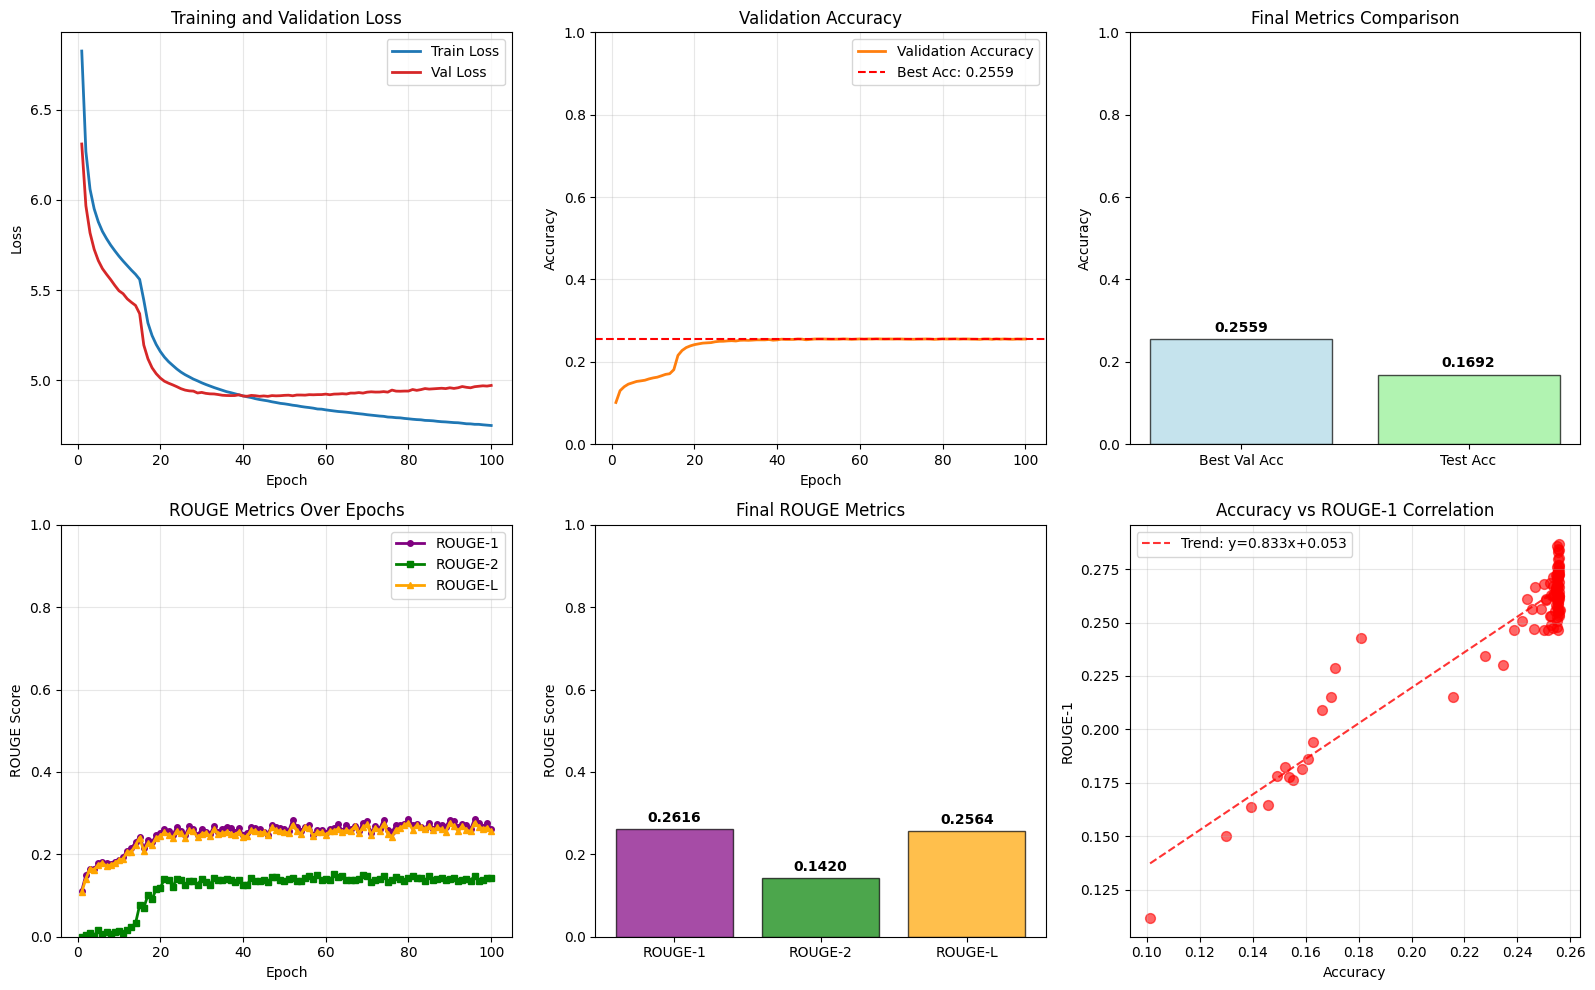

📊 Графики сохранены в: training_results.png


In [14]:
# Визуализация результатов

create_visualization(
    train_losses=train_losses,
    val_losses=val_losses,
    val_accuracies=val_accuracies,
    best_val_acc=best_val_acc,
    test_accuracy=test_accuracy,
    val_rouge_metrics=val_rouge_metrics,
    #test_rouge_metrics=test_rouge,  # если есть тестовые ROUGE метрики
    config=config
)


print(f"📊 Графики сохранены в: training_results.png")
